In [1]:
%pwd

u'/Users/hittu/workspace/hittudiv/courses/deeplearning1/nbs'

In [180]:
import os
base= os.getcwd() + "/data/redux"
base= os.getcwd() + "/data/redux/sample"
train= base+"/train"
test= base+"/test"
valid= base+"/valid"
results_path = base+"/results"

In [182]:
from matplotlib import pyplot as plt
import bcolz
def plot(img):
    plt.imshow(img)
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [166]:

    
import json   
import keras.preprocessing.image as preprocess
from keras.models import Sequential
import numpy as np
from keras.layers.core import Lambda, Flatten, Dropout, Dense
from keras.layers.convolutional import ZeroPadding2D, Convolution2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.optimizers import Adam
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
#     print x
#     import pdb;pdb.set_trace()
    return x[:, ::-1] # reverse axis rgb->bgr

class hgg:
    def get_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

    def get_batches(self,path, shuffle=True, batch_size=8, rotation_range=10 ,width_shift_range=10, height_shift_range=10, shear_range=0.3 ):
#         imageGenerator doc at https://keras.io/preprocessing/image/
        imageGenerator = preprocess.ImageDataGenerator(
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            shear_range=shear_range,
#             zoom_range=0
        )
        return imageGenerator.flow_from_directory(
            shuffle=shuffle,
            directory=path, 
            target_size=(224,224),
            batch_size=batch_size
        )
    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'

        self.createModel()
        self.get_classes()
        pass
    def createModel(self,):
        # Sequential doc at https://keras.io/getting-started/sequential-model-guide/
        model=self.model=Sequential()
        model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
        self.addConvLayer(2,64)
        self.addConvLayer(2,128)
        self.addConvLayer(3,256)
        self.addConvLayer(3,512)
        self.addConvLayer(3,512)
        
        self.model.add(Flatten())
        
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        
        
        self.model.add(Dense(1000,activation='softmax'))
        
        
        fname="vgg16.h5"
        self.model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))
        
    def addConvLayer(self,layers,filters):
        # Convolution2D https://keras.io/layers/convolutional/
        for i in range(layers):
            self.model.add(ZeroPadding2D((1,1)))
            self.model.add(Convolution2D(filters,3,3,activation='relu'))
        self.model.add(MaxPooling2D((2,2),strides=(2,2)))
        
    def ModifyLastLayerToNewOutput(self, no_of_outputs):
        self.model.pop()
        for layer in self.model.layers: layer.trainable=False
        self.model.add(Dense(no_of_outputs,activation='relu'))
        self.compile()
    def finetune(self,batch):
        self.ModifyLastLayerToNewOutput(batch.nb_class)
        self.classes = batch.class_indices.keys()
        for k,v in batch.class_indices.iteritems():
            self.classes[v]=k 
        
        
    def compile(self, lr=0.01):
        self.model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy',metrics=['accuracy'])
    def fit(self,train_batches, validation_batches):
        self.model.fit_generator(train_batches, 
                        samples_per_epoch = train_batches.nb_sample,
                        nb_epoch=1, 
                        validation_data = validation_batches,
                        nb_val_samples = validation_batches.nb_sample,
                        pickle_safe=True
                       )
   
h = hgg()
    

In [167]:
train_batches = h.get_batches(train)
validation_batches = h.get_batches(valid)
test_batches = h.get_batches(test)
# validation_batches
# plot(validation_batches)


Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 3 images belonging to 1 classes.


In [168]:
h.finetune(train_batches)

In [153]:
train_now=True
no_of_epochs=5
if train_now==True:
    latest_weights_filename = None
    for epoch in range(no_of_epochs):
        print "Running epoch: %d" % epoch
        if(epoch>=3):
            h.model.optimizer.lr = 0.001
        h.fit (train_batches, validation_batches)
        latest_weights_filename = 'ft%d.h5' % epoch
        h.model.save_weights(results_path+latest_weights_filename)
    print "Completed %s fit operations" % no_of_epochs
else:
    print "loading from saved_model"
    h.model.load_weights(results_path+"ft4.h5")


Running epoch: 0
Epoch 1/1


KeyboardInterrupt: 

In [154]:
??preprocess.ImageDataGenerator

In [171]:
preds=h.model.predict_generator(test_batches, test_batches.nb_sample)

In [173]:
is_dog = np.round(1- preds)
print is_dog[:5]
filenames = test_batches.filenames
print filenames[:5]

[[ 1. -0.]
 [ 1.  1.]
 [ 1. -1.]]
['unknown/17.jpg', 'unknown/23.jpg', 'unknown/4.jpg']


In [174]:
with open("submit.txt","a") as f:
    f.write("id,label\n")
    for i in range(len(preds)):
        if(is_dog[i][0]==1):
            is_dog[i][0]=0.95
        else:
            is_dog[i][0]=0.05
        print filenames[i][8:-4],",",is_dog[i][0]
        f.write("%s,%s\n"%(str(filenames[i][8:-4]),str(is_dog[i][0])) )

17 , 0.95
23 , 0.95
4 , 0.95


[[ 0.          1.33722055]
 [ 0.          0.        ]
 [ 0.          1.8042407 ]]


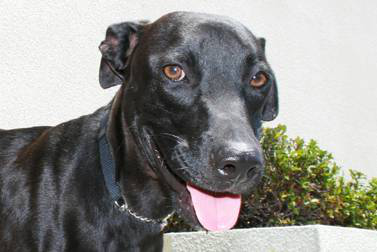

In [178]:
from PIL import Image
idx=1
print preds
Image.open(test+"/" + filenames[idx])

In [185]:
save_array(results_path + '/test_preds.dat', preds)
save_array(results_path + '/filenames.dat', filenames)